In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from catboost import CatBoostClassifier

from sklearn.datasets import load_iris, fetch_covtype, load_digits, make_classification, make_blobs
from statsmodels.stats.diagnostic import acorr_ljungbox # критерий значимости автокорреляции
import statsmodels.api as sm
# time series 
from statsmodels.graphics.tsaplots import plot_acf # построение коррелограммы
from statsmodels.tsa.stattools import acf, adfuller # acf = auto corr func; adfuller = DF test
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# собственные библиотеки
import imp # imp.reload
import ml_tools as ml
import help_tools as ht
import eda_tools as eda
import datetime
from prophet import Prophet
from IPython.display import display, HTML

https://education.yandex.ru/handbook/ml/article/vremennye-ryady  
https://github.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/blob/main/code/Ch11/colab%20version/Chapter_11_colab_version.ipynb

---
Временной ряд - набор случ значений x1, x2, ... соответствующий упорядоченным моментам времени t1, t2, ...  
Для простоты будем считать, что xi - значение метрики x в момент времени t=i (i - номер отрезка времени)  
Прогноз ряда - используя x1, x2, ... xn, получить предсказания xk, xk+1, ... в будущем (k>n)  
Далее будем рассматривать решение задачи прогнозирования временных рядов  
  
По типу прогнозирования можно выделить два подхода:
1. прогноз через ML - обучаем на исторических данных модель предсказывать следующие значения ряда  
2. эконометрический прогноз - анализируем статистические свойства ряда (тренд, сезонность, дисперсия ...)  
и на базе данных значений предсказываем будущее развитие ряда. В отличие от ML подхода необходимо  
понимание внутренней структуры данных ряда

#### Прогнозирование через ML модели

<u>ML модели для прогнозирования</u>  
Основная идея - обучить model.fit({x1, x2, ... xn, y(t1), ...}, xn+1) -> model.predict(tk) предсказывать 1 шаг.   
Затем распространить предсказания на несколько шагов (см ниже стратегии многошаговых прогнозов).  
Здесь xi (i<k) - ключевая метрика в прошлые моменты времени, y - другие ковариаты и дополнительные признаки.  
  
Простейший вариант model=ols({x1,x2,...xn}, xn+1) регрессии может показать тренд, но не сможет учесть  
сложные нелинейные закономерности во временном ряде. Поэтому используют более сложный набор прошлых  
признаков и нелинейные модели (например, древесные или нейросейти)
  

<u>Обучение модели предсказания следующего шага xk</u>  
- выделяем выборку моментов t1, t2, .. tn; пусть мы теперь предсказываем x(tn+1) - таргет
- выбираем ширину окна в прошлое (например N=3) - значит смотрим на 3 последние значения
- для семпла x(tn+1) имеем признаки: x(tn), x(tn-1), x(tn-2) = **лаговые** признаки,  
а также дополнительные признаки (например, day_of_week(tn+1), day_of_week(tn-1), y(tn-1) итд)    
- проходимся по всем ti из обучающей выборки - формируем обучающую таблицу (скользящую)
- используем модель для предсказания таргета по сформированным лаговым и дополнительным признакам
  
<u>Извлечение дополнительных признаков</u>  
Из даты можно извлечь такую информацию: год/месяц/день/час/минута/секунда, день недели, сезон года, праздник ли  
При необходимости данные фичи можно извлекать из текущего момента t_n+1, а также из лаговых моментов.  
Кроме того, можно добавлять статистики вроде: сглаженное/взвешенное среднее, min/max, другие статистики  
!!! Статистики и точные признаки можно использовать по прогнозируемой метрике x или по др. ковариатам.  
Пример: для прогноза температуры на завтра: понедельное среднее температуры/влажности на прошлых неделях    
Для учета сезонности можно использовать лаговые признаки по прошлым периодам, например прошлый год та же неделя,  
среднее по N прошлым годам в эту неделю итд.  
  
<u>Отличие от классической регрессии</u>
- обучающие семплы зависимы (так как перекрываются во времени с соседними)
- порядок признаков имеет значение (для каждого таргета фиксированный набор лаговых моментов времени)  
  
<u>Прогнозирование для N шагов (например, на N дней вперед) - многошаговая модель</u>  
1. Рекурсивная стратегия - обучили модель предсказывать на один шаг. Предсказали следующий, подали на вход со  
смещением, предсказали следующий (теперь один из лаговых признаков - прошлый прогноз) итд.  
2. Прямая стратегия - для каждого момента tn+1, tn+2, ... строится отдельная модель на данных (tn-w, ... tn)  
по сути модели отличаются смещением таргета относительно лаговых признаков
3. Гибридная - строим отдельные модели, но используя для следующего момента времени прогнозы предыдущих.  
  
<u>Оценка качества модели</u>  
Можно использовать метрики аналогичные регрессионным задачам: RMSE, MAE, MAPE ...  
Кросс-валидация классическая невозможна, так как моменты времени нельзя перемешивать в обучающей выборке.  
Вариант, двигаться со смещением: 
- обучаемся на t1,t2,tn -> предсказываем tn+1, tn+2 ... (если нужно несколько значений)  
- обучаемся на t1+delta,t2+delta, ... -> предсказываем tn+1+delta, tn+2+delta, ...  
Полученные скоры обучений усредняем - оцениваем качество модели  
  
<u> Недостатки  и достоинства прогнозирования временных рядов через ML</u>  
Достоинства:   
- могут свободно использовать большой скоуп дополнительных признаков
- удобно расширяются на прогнозирование сразу нескольких временных рядов через нейронки
  
Недостатки:  
- нельзя получить доверительные интервалы напрямую (только долгий бутстрап)
- сложности в интерпретации
- вычислительная сложность и сложность извлечения признаков

#### Прогнозирование через статистические модели

https://education.yandex.ru/handbook/ml/article/analitika-vremennyh-ryadov
https://habr.com/ru/companies/ods/articles/327242/
  
Прогнозирование через статистические (эконометрические) модели использует знания о  
структуре временного ряда для прогнозирования будущих значений.  

<u>ДЕКОМПОЗИЦИЯ ВРЕМЕННОГО РЯДА</u>  
Ряд в реальной жизни имеет следующие компоненты:
- тренд (долгосрочное направление развития)
- сезонность (повторяющиеся колебания - годовые (время года), недельные (выходные), суточные (день-ночь))
- шум (случайные отклонения)
  
Аддитивная или мультипликативная декомпозиция ряда:  
y(t) = Tt + St + Nt; y(t) = T * S * N  
  
<u>АВТОКОРРЕЛЯЦИЯ</u>  
Ряд x1, x2, ... это набор зависимых значений (xN зависит от xP; P < N)  
R(dt) = corr(xt, xt+dt) - корреляционная функция от сдвига dt (для всех пар точек t,t+dt ряда)  
Например R(1) для прогноза температуры - это то как усредненно вчерашняя темп-пра влияет на сегодняшнюю.  
R > 0 -> чем выше была вчера, тем выше сегодня итд. R = 0 - лин. корреляции нет, но не значит что нет зависимости. 

PS. R = автокорреляция, так как оценивается корреляция ряда с самим собой.  
Стат. значимость R>0 для ряда можно проверять критерием Ljung-Box: расчет p_val по группе лагов  
Оценка дов интервала acf также возможна, но вычисляется для каждого лага **отдельно**  
  
Коррелограмма - график зависимости автокорреляции ряда от его лага dt.  
Позволяет анализировать как фиксированные значения ряда зависят от его значений в прошлом на t-dt.  
По коррелограмме можно оценивать также какие лаговые признаки y(t-dt) стат значимо влияют на таргет y в ML

Тест на ACF>0, Y = white noise, pval=0.5030878152363978, ACF=[-0.03787909  0.08714547]
Тест на ACF>0, Y = trend, pval=0.0, ACF=[0.68552788 1.20359994]


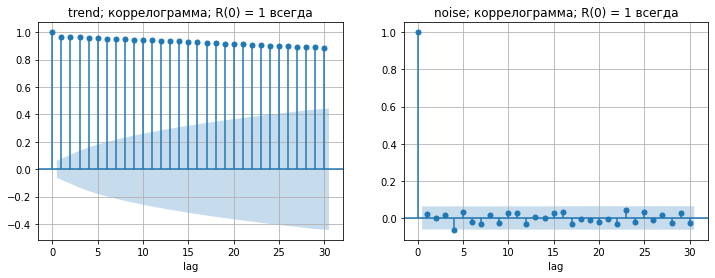

In [21]:
# Проверки и вычисления автокорреляции (ACF)
data_noise = np.random.normal(size=1000, scale = 50)
data_trend = list(np.arange(1000)) + data_noise

pval = acorr_ljungbox(data_noise, lags=[10], return_df=True).lb_pvalue.iloc[0] # lag = смещение автокорреляции
r_corr = acf(data_noise, nlags=10, alpha=0.05)[1][10]
print(f'Тест на ACF>0, Y = white noise, pval={pval}, ACF={r_corr}')

pval = acorr_ljungbox(data_trend, lags=[10], return_df=True).lb_pvalue.iloc[0] # lag = смещение автокорреляции
r_corr = acf(data_trend, nlags=10, alpha=0.05)[1][10]
print(f'Тест на ACF>0, Y = trend, pval={pval}, ACF={r_corr}')

# Строим коррелограмму
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_acf(data_trend, alpha=0.05, ax=ax[0], title='trend; коррелограмма; R(0) = 1 всегда')
plot_acf(data_noise, alpha=0.05, ax=ax[1], title='noise; коррелограмма; R(0) = 1 всегда')
ax[0].set_xlabel('lag'); ax[1].set_xlabel('lag'); ax[1].grid(True); ax[0].grid(True); 

<u>СТАЦИОНАРНОСТЬ</u>  
Стационарный ряд - это ряд, стат свойства членов которого не зависят от момента времени t
1. avg(xt) = const - отсутствие тренда от t
2. std(xt) = const < inf - ряд гетероскедастичен, для разных t размах относительно нуля постоянен
3. cov(xt, xt+dt) = cov(dt) - частотность постоянна (плотность вероятности относительно прошлого)
  
Стационарный ряд <u>предсказуем</u> - а значит по нему просто делать прогнозы.  
Основная мысль: если ряд не стационарный - то попробовать преобразованиями привести его к стационарному.  
Пример: t = 1, 2, 3, ... месяцы в году; x1, x2, ... случ величины реализующиеся в эти моменты времени  
Мы говорим что для любого момента  t: avg(xt) = const итд.  
Если есть тренд: x = a * t + et, то avg(x_0) = 0; avg(x_1) = a > 0 - ряд не стационарен  
Здесь и далее et = <u>белый шум</u>
  
<u>Random walk. Модель случайного блуждания</u>  
Y(t) = k * Y(y-1) + e(t)  
M(e) = 0 (среднее), тогда M(y) = M(k^t * y0) + M(... * e) + ... + M(e) = c * M(y0) = 0  
Первое условие стационарности выполняется  
  
Var(Y) = Var(k^t * e) + Var(k^t-1 * e^2) + ... + Var(e)  
Когда k = 1 -> Var(Y) = t * Var(e) - зависит от t и ряд **нестационарный**  
Когда k < 1 при больших t -> геометрическая прогрессия -> Var(Y) = Var(e) / (1 - k) - ряд **стационарный**  
  
<u>Критерий Дикки-Фуллера</u>  
Критерий проверки временного ряда на стационарность. Возьмем произвольный временной ряд xt. dx = xt - xt-1.  
Представим через ols список разностей dx = alpha1 + alpha2 * t + alpha3 * xt-1 + et  
Идея: если dx плохо объясняется через xt-1 (коэф alpha3) то ряд не стационарный.  
alpha2 - поправка на тренд, т е alpha3 покажет стационарность после вычитания тренда.  
alpha3 < 0 -> при положительном xt-1 идет тенденция возвращения к нулю и наоборот.  
аналогия с колебаниями, где сила тяжести в любой момент стремится вернуть маятник против отклонения.  
Тест DF смотрит на распределение alpha2 и оценивает p_val его отличия от нуля  
PS. Для random walk alpha3 = k - 1 -> alpha3 < 0 = k < 1, см рассуждения random walk выше.  
PSS. alpha3 > 0 = лавинные взрывные процессы соответствующие разгону амплитуды dxt.  

In [35]:
n_samples = 1000
data_noise = np.random.normal(size=n_samples, scale = 50)
data_trend = list(np.arange(n_samples)) + data_noise

# random walk init eps = noise
x_0 = np.zeros(n_samples); x_1 = np.zeros(n_samples); k0, k1 = 0.5, 1
eps = np.random.normal(size=n_samples)
for t in range(1, n_samples):
    x_0[t] = k0 * x_0[t-1] + eps[t]
    x_1[t] = k1 * x_1[t-1] + eps[t]

print(f'p_val DF noise: {np.round(adfuller(data_noise)[1], 4)}; stationary')
print(f'p_val DF trend: {np.round(adfuller(data_trend)[1], 4)}; not stationary')
print(f'p_val DF random walk k=0.5: {np.round(adfuller(x_0)[1], 4)}; stationary')
print(f'p_val DF random walk k=1: {np.round(adfuller(x_1)[1], 4)}; not stationary')

p_val DF noise: 0.0; stationary
p_val DF trend: 0.9463; not stationary
p_val DF random walk k=0.5: 0.0; 
p_val DF random walk k=1: 0.1978; 


<u>ПРЕОБРАЗОВАНИЕ РЯДА К СТАЦИОНАРНОМУ</u>  
Некоторые модели требуют приведение ряда к стационарному.  
Приведение ряда к стационарному включает несколько этапов:  
1. Проверка ряда на корректность (заполнение пропусков, выбросы и пр)  
2. Стабилизация дисперсии (std = const)
3. Устранение тренда (чтобы avg(t) = const)  
4. Устранение сезонности (также чтобы avg(t) = const)
4. Предсказание значений (разные модели вроде AR, ARMA ...)  
5. Обратное преобразование
  
Стабилизация дисперсии - устраннение зависимости дисперсии процесса от времени. Можно осуществлять через  
нормирование xt/D(t) если известна форма зависимости D, уменьшает гетероскедастичность логарифмирование и  
преобразование Бокса-Кокса (см раздел Box-Cox тетради Статистика). Есть более сложные предиктивные модели.  
  
Устранение тренда и сезонности. Производится разностным диференциированием. Переход от ряда xt к ряду  
xt - shift(xt, 1) = xt - xt-1 нивелирует тренд. Переход xt - shift(xt, s) - где s - сезон, сезонность.  
Обратное преобразование для восстановление ряда - интегрирование (соответственно shift(-s) + x_diff)  
Если после интегрирования ряда d раз (в общем случае с разными shift=s=seassonal period) ряд становится  
стационарным - то можно делать его прогноз, а дальше восстанавливать последовательным интегрированием.  

y не стац pval= 0.695 y_transform стац pval= 1.07397234e-07


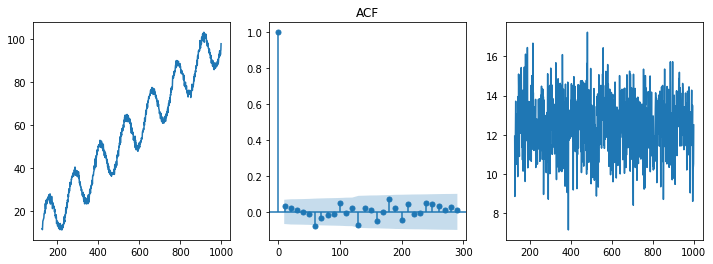

In [136]:
# Диф разность = здесь мы разом устраняем и тренд и влияние сезонности
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
n = 1000; t = np.arange(n); y = 0.1 * t + 10 * np.sin(0.05 * t) + np.random.normal(scale = 1, size = n)
df = pd.DataFrame({'t' : t, 'y' : y})

shift = int(2 * np.pi / 0.05) # период = сезонность
df['y_transform'] = df.y - df.y.shift(shift) ; df = df[shift:]
plot_acf(df.y_transform, alpha=0.05, ax=ax[1], title='ACF', lags=np.arange(0, 300, 10))
print('y не стац pval=', np.round(adfuller(df.y)[1], 3),
      'y_transform стац pval=', np.round(adfuller(df.y_transform)[1], 15))
ax[0].plot(df.t, df.y); ax[2].plot(df.t, df.y_transform); plt.show()

<u>ПРОГНОЗИРОВАНИЕ</u>  
  

<u>Прогнозирование через сглаживание</u>  
https://education.yandex.ru/handbook/ml/article/analitika-vremennyh-ryadov  
Сглаживание устранняет шум (возможны разные режимы работы в зависимости от наличия тренда, сезонности)  
При использовании каскада сглаживаний - не требуется приводить ряд к стационарному.  
  
Сглаживание, как задача минимизации:  
- задача аналогична OLS, где минимизируем функционал разности L(y, y_forecast)
- в OLS y_forecast = k1 * x1 + ... kn * xn; коэфф при ковариатах постоянные (линейная модель)  
- при сглаживании (модель Хольта) y_forecast = alpha * yt-1 + alpha(1 - alpha) * yt-2 ...
ковариаты = лаговые признаки, коэфф экспоненциально убывают со временем от величины лага
- далее мы считаем L(y, y_forecast) -> min -> коэф для y_forecast
    
Экспоненциальное сглаживание:
st = alpha * yt + (1 - alpha) * st-1; сглаженное значение зависит от текущего и предыдущего с весами от alpha  
при изменении alpha относительное влияние предыдущих членов и текущего меняются - подход более гибкий чем  
скользящее среднее (где веса последовательных членов одинаковые, а управление через ширину окна)  
  
- Простое эксп сглаживание: сглаживаем yt, для стац рядов без тренда и сезонности y_forecast = st + delta
- Двойное сглаживание: Определяем тренд bt через разностное дифференциирование, сглаживаем его, затем подставляем  
в формулу для yt и также сглаживаем вместе с трендом
- Тройное сглаживание:  добавляем сглаженную сезонность, которая также определяется через diff.  
  
В зависимости от типа сглаживания будет больше гиперпараметров сглаживания (на каждом уровне)  
Если мы знаем, что у модели нет тренда, сезонности итд - то лучше использовать соответственную простую модель  

---
<u>SARIMAX</u>  
https://education.yandex.ru/handbook/ml/article/modeli-vida-arima  
Семейство прогнозирующих моделей с последовательными усложнениями в зависимости от общности ряда.  
SARIMAX = S + AR + I + MA + X  
  
1. MA(q) - mean avg - модель предсказания y(t) = avg + et + at-1 * et-1 + ... at-q * et-q  
q - ширина окна; et-k остатки модели для лага k. Работает только для стационарных рядов.  
et-k  отклонения значения yt-k от среднего avg посчитанного в данном окне q.  
Идея: остатки (aka шумы) зависимы на соседних лагах - если раньше были большие, то и сейчас будут итд.  
  
  
2. AR(p) - auto regr - модель авторегрессии (регрессия по своим же лаговым признакам)  
yt = a_const + at-1 * yt-1 + ... + at-p * yt-p + et   
p - ширина окна для отбора лаговых признаков. Также работает для стационарных рядов (нет трендов, сезонности)  
Идея: считаем, что текущее значение ряда зависит от недавних значений и некоторого шума  
В зависимости от p получаем разные AR(p) процессы - ряды, описываемые данным уравнением.  
AR(1): yt = a + k * yt-1 = random walk (рассматривали выше при описании стационарности)    


3. ARIMA(p, q, d) = I_d * (AR + MA)  
ARMA(p, q) = модель для предсказаний стационарного ряда, когда представляем yt = MA(y, q) + AR(y, p)  
I = integrated d -> когда ряд имеет тренд, то его сначала дифференциируют d раз до стационарности,  
затем делают прогноз через ARMA, затем обратно интегрируют.  
Т е ARIMA работает для рядов с трендом (расширение для нестационарных рядов)  
  
  
4. SARIMA = Seassonal + ARIMA  
Пусть нам известна некоторая сезонность ряда s (можно оценить визуально, через Фурье-спектр или пики ACF)  
Тогда привести ряд к стационарному дополнительно можно выполнив сезонное диф порядка s: D_s  
Если сезонность сложная (например, периодич функция порядка s1 вложена в др функцию порядка s2 итд)  
тогда нужно делать D дифференциирований последовательно с лагами s1, s2 ...  
также подбираются параметры P, Q - это аналоги p, q но с шагом в s (то есть значения ряда в прошлых сезонах)  
например для p=3: yt = a + a1 * yt-s + a2 * yt-2s итд.  
  
5. X = exogen factors  
Обогащаем модель экзогенными факторами = внешними ковариатами в моменты времени t-1, t-2 ...  
которые могут улучшить предсказание yt, по сути добавляем их также в регрессию  

---
<u>Оптимизация SARIMAX</u>  
В общем случае имеем модель y = SARIMAX(p,q,d,P,Q,D,x; y_prev)  
Далее мы предсказываем будущие значения forecast, вычисляем функционал L(forecast, y)  
и подбираем гиперпараметры минимизируя его. Перед этим оцениваются примерные интервалы перебираемых параметров.  
1. p,q - через ACF, PACF. Для q смотрим через сколько лагов ACF станет не стат значимой -> выбираем порог q  
Для p смотрим PACF - частичная (particial) автокорреляция. Строим регрессию yt ~ yt-1 + ... yt-k  
смотрим влияние yt-k (лага k) на yt БЕЗ учета всех промежуточных лагов (чистая взаимосвязь)  
PACF(p) -> не стат значима, берем p как оптимальное значение для SARIMAX  
2. d, D(s) - дифференциируем Y до тех пор пока не станет стационарным, оставляем эти d, D(s)  
3. P,Q - также по PACF, ACF но с шагом сезонности, обычно не очень большие



---
<u>Метрики оптимизации</u>  
Качество модели можно определять по тому насколько прогноз forecast близок к реальным тестовым результатам  
L(forecast, y). Варианты функционала для временных рядов:  
1) RMSE = root mean sq error = sqrt(avg(forecast^2 - y^2))  
штрафует за выбросы пропорционально квадрату -> прогноз не должен расходиться очень сильно ни в одной  
локальной точке (когда важно чтобы не было сильных выбросов в остатках модели)  
2) MAE = mean abs error = avg(|forecast - y|)  
не так сильно штрафует за локальные выбросы в остатках - интересует близость рядов в среднем  
3) MAPE = mean abs perc error = avg(100 * |(forecast - y) / y|)  
минимизируем относительное различие рядов в процентах  


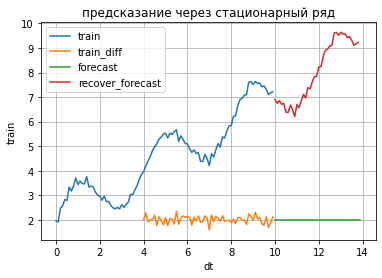

In [239]:
# ПРИМЕР ПРИВЕДЕНИЯ РЯДА К СТАЦИОНАРНОМУ, ПРЕДСКАЗАНИЕ ЧЕРЕЗ СГЛАЖИВАНИЕ - ИНТЕГРИРОВАНИЕ ОБРАТНО
dt_full = np.arange(0, 14, 0.1)
dt = np.arange(0, 10, 0.1)
# функция с трендом и сезонностью с периодом T = 20 (размерность dt = 0.1)
train = 2 + 0.5 * dt + np.sin( np.pi * dt / 2) + np.random.normal(scale=0.1, size=len(dt)) 

df = pd.DataFrame({'dt' : dt_full})
df['train'] = np.nan
df.loc[df['dt'].isin(dt), 'train'] = train

df['train_dif'] = df.train.diff(periods=40)

forecast = ExponentialSmoothing(df.train_dif[40:100]).fit(optimized=True).forecast(40)
df.loc[100:140, 'forecast'] = forecast

forecast_recover = forecast + df.loc[100-39:100, 'train'].values
df.loc[100:140, 'forecast_recover'] = forecast_recover

eda.make_plot('line', {'x' : df.dt, 'y' : df.train})
eda.make_plot('line', {'x' : df.dt, 'y' : df.train_dif})
eda.make_plot('line', {'x' : df.dt, 'y' : df.forecast})
eda.make_plot('line', {'x' : df.dt, 'y' : df.forecast_recover})
plt.legend(['train', 'train_diff', 'forecast', 'recover_forecast'])
plt.title('предсказание через стационарный ряд')
plt.grid()

13:31:18 - cmdstanpy - INFO - Chain [1] start processing
13:31:18 - cmdstanpy - INFO - Chain [1] done processing


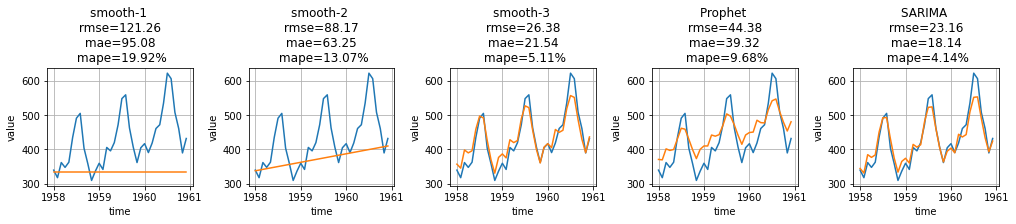

In [44]:
# ПРИМЕРЫ НЕСКОЛЬКИХ МОДЕЛЕЙ СГЛАЖИВАНИЯ, PROPHET ДЛЯ ПРЕДСКАЗАНИЯ РЯДОВ
# реальный пример данных обладающих трендом и сезонностью
data = sm.datasets.get_rdataset("AirPassengers", package="datasets").data
data = data.sort_values(by='time', ascending=True)
data_train = data[data.time < 1958]
data_test = data[data.time >= 1958]
dt, real = data_test.time, data_test.value

# Метрики оценки точности
def get_mae(y_true, y_pred):
    return np.round(np.mean(np.abs(y_true - y_pred)), 2)
def get_rmse(y_true, y_pred):
    return np.round(np.sqrt(np.mean((y_true - y_pred) ** 2)), 2)
def get_mape(y_true, y_pred):
    return np.round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


# графики для визуализации
ax = eda.get_subplots((14, 3), 1, 5)

# ПРЕДИКТИВНЫЕ МОДЕЛИ
# одношаговое сглаживание - без тренда и сезонности
forecast = ExponentialSmoothing(data_train.value).fit(optimized=True).forecast(36)
rmse, mae, mape = get_rmse(real, forecast), get_mae(real, forecast), get_mape(real, forecast)
params_real = {'x' : dt, 'y' : real, 'ax' : ax[0], 'title' : f'smooth-1 \n rmse={rmse} \n mae={mae} \n mape={mape}%'}
params_forecast = {'x' : data_test.time, 'y' : forecast, 'ax' : ax[0]}
eda.make_plot('line', params_real); eda.make_plot('line', params_forecast)

# одношаговое сглаживание - только тренд
forecast = ExponentialSmoothing(data_train.value, trend='add').fit(optimized=True).forecast(36)
rmse, mae, mape = get_rmse(real, forecast), get_mae(real, forecast), get_mape(real, forecast)
params_real = {'x' : dt, 'y' : real, 'ax' : ax[1], 'title' : f'smooth-2 \n rmse={rmse} \n mae={mae} \n mape={mape}%'}
params_forecast = {'x' : data_test.time, 'y' : forecast, 'ax' : ax[1]}
eda.make_plot('line', params_real); eda.make_plot('line', params_forecast)

# трехшаговое сглаживание - тренд и сезонность
forecast = ExponentialSmoothing(data_train.value, trend='add', seasonal="add", seasonal_periods=12).fit(optimized=True).forecast(36)
rmse, mae, mape = get_rmse(real, forecast), get_mae(real, forecast), get_mape(real, forecast)
params_real = {'x' : dt, 'y' : real, 'ax' : ax[2]}
params_forecast = {'x' : dt, 'y' : forecast, 'ax' : ax[2], 'title' : f'smooth-3 \n rmse={rmse} \n mae={mae} \n mape={mape}%'}
eda.make_plot('line', params_real); eda.make_plot('line', params_forecast)

# Prophet - модель от фейсбук
# тюнинг формата данных для таблиц
tmp = data_train.rename(columns={'time' : 'ds', 'value' : 'y'})
def get_date(x):
    year = int(x)
    month = round(12 * (x - int(x))) + 1
    return datetime.datetime(year, month, 1)
tmp.ds = tmp.ds.apply(get_date)
model = Prophet(yearly_seasonality=True); model.fit(tmp)
forecast = model.predict(model.make_future_dataframe(periods=36, freq='MS')).yhat
rmse, mae, mape = get_rmse(real, forecast), get_mae(real, forecast), get_mape(real, forecast)
params_real = {'x' : dt, 'y' : real, 'ax' : ax[3]}
params_forecast = {'x' : dt, 'y' : forecast, 'ax' : ax[3], 'title' : f'Prophet \n rmse={rmse} \n mae={mae} \n mape={mape}%'}
eda.make_plot('line', params_real); eda.make_plot('line', params_forecast)

# SARIMA
p,q,d = 1,1,1; P,Q,D,s = 1,1,1,12
model = SARIMAX(data_train.value, order=(p,d,q), seasonal_order=(P,D,Q,s))
forecast_data = model.fit().get_forecast(steps=36) # conf_int = forecast_data.conf_int()
forecast = forecast_data.predicted_mean.values
rmse, mae, mape = get_rmse(real, forecast), get_mae(real, forecast), get_mape(real, forecast)
params_real = {'x' : dt, 'y' : real, 'ax' : ax[4]}
params_forecast = {'x' : dt, 'y' : forecast, 'ax' : ax[4], 'title' : f'SARIMA \n rmse={rmse} \n mae={mae} \n mape={mape}%'}
eda.make_plot('line', params_real); eda.make_plot('line', params_forecast)

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller 

In [4]:
# ТЮНИНГ ПАРАМЕТРОВ SARIMAX
data = sm.datasets.get_rdataset("AirPassengers", package="datasets").data
data = data.sort_values(by='time', ascending=True)
data_train = data[data.time < 1958]
data_test = data[data.time >= 1958]
dt, real = data_test.time, data_test.value

# TODO поместить данные функции в ml_tools - time series
# ф ия возвращающая ACF, PACF датасеты от лагов (принимает лаги), а также при необх строит plot

# функция дифференциирующая Y принимающая на вход [s1, s2, ...]; s=1 трендовое, s>1 сезонное  
# рисует ряд, возвращает критерий стационарности Дикке  
  
# пайплайн перебора sarimax с поиском минимального L   

In [51]:
def get_acf(ts_list, lags = 40, plot=True, alpha=0.05, figsize = (10, 4)):
    """вычисляем ACF, PACF для временного ряда ts_list на диапазоне лагов (1, lags)
    При необходимости строим график для автокорреляции
    args: ts_list, lags = 40, plot=True, alpha=0.05, figsize = (10, 4)
    return: plot + df_stat = acf, pacf info
    """
    df_acf, df_pacf = acf(ts_list, nlags=lags, alpha=alpha), pacf(ts_list, nlags=lags, alpha=alpha)
    df_stat = pd.DataFrame({'acf' : df_acf[0], 'acf_low' : df_acf[1].T[0], 'acf_high' : df_acf[1].T[1], 
                  'pacf' : df_pacf[0], 'pacf_low' : df_pacf[1].T[0], 'pacf_high' : df_pacf[1].T[1]})
    df_stat['acf_sign'] = ((df_stat.acf_low * df_stat.acf_high) > 0).astype(int)
    df_stat['pacf_sign'] = ((df_stat.pacf_low * df_stat.pacf_high) > 0).astype(int)
    df_stat['lag'] = range(lags + 1)
    if plot:
        ax = eda.get_subplots(figsize, 1, 2)
        plot_acf(ts_list, ax[0])
        plot_pacf(ts_list, ax[1])
    return df_stat[['lag', 'acf', 'acf_low', 'acf_high', 'acf_sign', 'pacf', 'pacf_low', 'pacf_high', 'pacf_sign']]

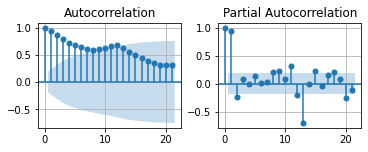

In [52]:
df_stat = get_acf(data_train.value, figsize=(5, 2))

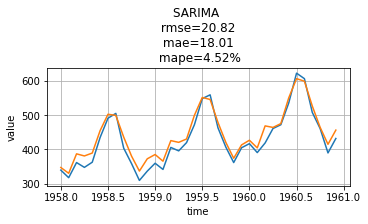

In [76]:
# SARIMA
ax = eda.get_subplots((5, 3), 1, 1)
def get_mae(y_true, y_pred):
    return np.round(np.mean(np.abs(y_true - y_pred)), 2)
def get_rmse(y_true, y_pred):
    return np.round(np.sqrt(np.mean((y_true - y_pred) ** 2)), 2)
def get_mape(y_true, y_pred):
    return np.round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)
p,d,q = 1,1,1; P,D,Q,s = 2,1,2,12
model = SARIMAX(data_train.value, order=(p,d,q), seasonal_order=(P,D,Q,s))
forecast_data = model.fit().get_forecast(steps=36) # conf_int = forecast_data.conf_int()
forecast = forecast_data.predicted_mean.values
rmse, mae, mape = get_rmse(real, forecast), get_mae(real, forecast), get_mape(real, forecast)
params_real = {'x' : dt, 'y' : real, 'ax' : ax}
params_forecast = {'x' : dt, 'y' : forecast, 'ax' : ax, 'title' : f'SARIMA \n rmse={rmse} \n mae={mae} \n mape={mape}%'}
eda.make_plot('line', params_real); eda.make_plot('line', params_forecast)